In [35]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from photutils import CircularAperture, aperture_photometry
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm_notebook
import matplotlib.gridspec as gridspec
from astropy import units

plt.rcParams['axes.linewidth']=3
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rc('xtick.major', size=8, pad=8)
plt.rc('xtick.minor', size=6, pad=5)
plt.rc('ytick.major', size=8, pad=8)
plt.rc('ytick.minor', size=6, pad=5)
plt.rcParams['font.size'] = 18


parula_colors = np.load('/Users/arcticfox/parula_colors.npy')

In [19]:
def discrete_star(res, limb_vals):

    x = np.linspace(-1.0, 1.0, res)
    y = np.linspace(-1.0, 1.0, res)

    z = np.ones(res**2).reshape(res,res)

    xx, yy = np.meshgrid(x, y, sparse=True)

    r = np.sqrt(xx**2 + yy**2)
    z[r >1] = 0

    lat = np.arcsin(yy)
    lon = np.arcsin(xx)

    v_diffrot = 100*z*np.cos(lat)*np.sin(lon) *np.cos(lat/1.0)
    v = 100*z*np.cos(lat)*np.sin(lon)

    limb = 1.0*(1-0.64*(1-np.cos(r*np.pi/2)))
    limb[r>1] = 0

    discrete_limb = np.zeros(limb.shape)

    for i in range(len(limb_vals)-1):
        discrete_limb[(limb >= float(limb_vals[i])) & 
                      (limb <  float(limb_vals[i+1]))] = float(limb_vals[i])
        
    return discrete_limb

In [20]:
def create_spot_features(dat):
    global spot, surface, faculae

    areas = np.zeros(3)
    weights = np.zeros(3)
    
    for i in range(3):
        where = np.where(dat[np.isnan(dat)==False]==i)[0] 
        weights[i] = len(where) #* areas[i]
        
        # Normalizes weights
    weights = weights/ np.nansum(weights)
    
        # Adds together spectra multiplied by appropriate weight
    spec = (spot[:,1][q] * weights[0]) + (surface[:,1][q] * weights[1])
    spec += (faculae[:,1][q] * weights[2])
    #print(weights)
    return spec

### Need to run the spectrum277 code for different limb darkening values
That code can be found [here](https://www.appstate.edu/~grayro/spectrum/spectrum.html).

In [21]:
def make_feature_table(lowlim=6561, upplim=6565):
    pwd = '/Users/arcticfox/Downloads/spectrum277/spot_spectra'
    
    for f, feature in enumerate(['spot', 'surface', 'faculae']):
        files = np.sort([os.path.join(pwd, i) for i in os.listdir(pwd)
                         if feature in i and i.endswith('.halpha')])
        
        for i in tqdm_notebook(range(len(files))):
            u = int(files[i].split('.')[0][-3:]) + (f*100)
            key = 'u{0:03d}_{1}'

            dat = np.loadtxt(files[i])

            if f == 0 and i == 0:
                q = ((dat[:,0] >= lowlim) & (dat[:,0] <= upplim))
                tab = Table(names=['wavelength', key.format(u, feature)],
                            data=[dat[:,0][q], dat[:,1][q]])
            else:
                tab.add_column(Column(dat[:,1][q], key.format(u, feature)))
    return tab

In [24]:
tab = make_feature_table()

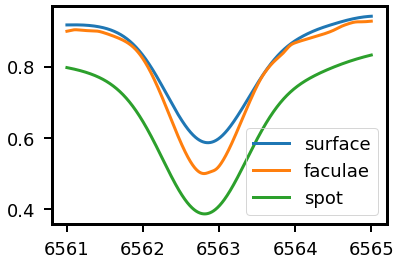

In [25]:
plt.plot(tab['wavelength'], tab['u000_spot'], label='surface', lw=3)
plt.plot(tab['wavelength'],  tab['u100_surface'], label='faculae', lw=3)
plt.plot(tab['wavelength'], tab['u200_faculae'], label='spot', lw=3)
plt.legend();

In [7]:
surface_dir = '/Users/arcticfox/Documents/atmospheres/v1298tau/spot_surfaces/best_fit'
surface_fns = np.sort([os.path.join(surface_dir, i) for i in os.listdir(surface_dir)
                       if i.endswith('.npy') and 'spot' in i])

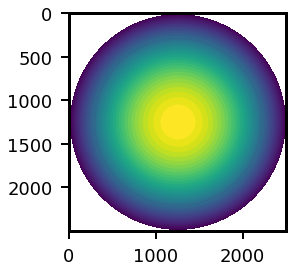

In [26]:
limb_vals = np.zeros(len(tab.colnames[1:51]))
for i in range(len(limb_vals)):
    limb_vals[i] = float(tab.colnames[i+1][1:4])/100.0

test = np.load(surface_fns[0], allow_pickle=True)
ld_star = discrete_star(test.shape[0], limb_vals)

x,y = np.where(ld_star==0)
ld_star[x,y] = np.nan
plt.imshow(ld_star)

In [27]:
def spot_and_darkening(ld_applied):
    global tab
    
    uni_map_vals = np.unique(ld_applied[np.isnan(ld_applied)==False])
    keys = ['{0:03d}'.format(int(i)) for i in uni_map_vals*100]

    weights = np.zeros(len(uni_map_vals))
    spec = np.zeros((len(uni_map_vals), len(tab['wavelength'])))

    for i, u in enumerate(uni_map_vals):
        weights[i] = len(np.where(ld_applied==u)[0])
        k = [t for t in tab.colnames if '{0:03d}'.format(int(np.round(u,2)*100)) in t]
        spec[i] = tab[k[0]] + 0.0

    weights = weights/ np.nansum(weights)
    weighted_spec = np.zeros(len(tab['wavelength']))

    for i in range(len(weights)):
        weighted_spec += (spec[i]*weights[i])

    return weighted_spec

In [28]:
for i in tqdm_notebook(range(len(surface_fns))):
    dat = np.load(surface_fns[i])
    
    spec = spot_and_darkening(dat+ld_star)
    
    if i == 0: 
        all_spec = np.zeros((len(surface_fns), len(spec)))
        
    all_spec[i] = spec + 0.0

In [15]:
np.save(os.path.join(surface_dir, 'simulated_spectra.npy'),
        all_spec)

In [29]:
template = np.nanmedian(all_spec[80:], axis=0)

In [30]:
equiv_widths = np.zeros(len(all_spec))
for i in range(len(all_spec)):
    equiv_widths[i] = np.nansum((all_spec[i]/template) - 1) * -1 

## Simulated results for V1298 Tau

In [31]:
lc = np.load(os.path.join(surface_dir,'simulated_lc.npy'), allow_pickle=True)
halpha = np.load(os.path.join('/Users/arcticfox/Downloads/spectrum277', 
                              'real_halpha.npy'), allow_pickle=True)

plot_dir = '/Users/arcticfox/Documents/atmospheres/v1298tau/figures/'

In [32]:
from pylab import *
colormap='YlOrRd_r'

cmap = cm.get_cmap(colormap, 20)

colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

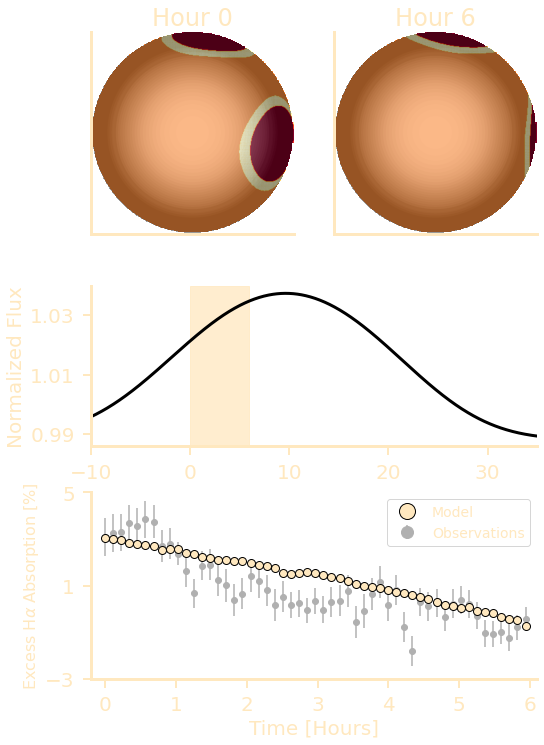

In [74]:
fig2 = plt.figure(constrained_layout=True, figsize=(8,12))
spec2 = gridspec.GridSpec(ncols=2, nrows=3, figure=fig2,
                          height_ratios=[2,1.5, 1.75])
ax1 = fig2.add_subplot(spec2[0, 0])
ax3 = fig2.add_subplot(spec2[0, 1])
ax2 = fig2.add_subplot(spec2[2, :])
ax4 = fig2.add_subplot(spec2[1, :])

norm_widths = equiv_widths/np.nanmedian(equiv_widths)
start=75

hl = np.where((lc[0]>=lc[2][0]) & (lc[0]<=lc[2][-1]))[0]
tlc_tot = (Time(lc[0], format='jd').mjd - Time(lc[0], format='jd').mjd[0]) * units.day
tlc_tot = tlc_tot.to(units.hour) - tlc_tot[hl][0]

plotting = np.linspace(tlc_tot[hl][0].value, tlc_tot[hl][-1].value, 53)

ax2.errorbar(plotting, halpha[0], yerr=halpha[1], marker='o', 
             ms=6, color='#b0b0b0', linestyle='', zorder=1,
             label='Observations')
ax2.plot(plotting, equiv_widths[start:start+53], 'o', color=colors[0],
         markeredgecolor='k', ms=8, label='Model')
ax2.legend(fontsize=14)

ax2.set_ylim(-3.0,5.0)
ax2.set_yticks(np.round(np.linspace(-3,5.0,3),1))
ax2.set_xlim(-0.2,6.1)
ax2.set_ylabel(r'Excess H$\alpha$ Absorption [%]', fontsize=16)
ax2.set_xlabel('Time [Hours]')


ax4.plot(tlc_tot.value-tlc_tot[hl][0].value, lc[1], 'k', lw=3)
ax4.set_xlim(-10,35)

ax4.axvspan(plotting[0], plotting[-1], color=colors[0],
            alpha=0.75)
ax4.set_ylabel('Normalized Flux')
ax4.set_yticks(np.round(np.linspace(0.99,1.03,3),2))


###########################
##### DRAWS THE MAPS #####
###########################

# LIMB DARKENING MAP #
mask = np.full(ld_star.shape, np.nan)
x,y = np.where(ld_star<0.5)
mask[x,y] = ld_star[x,y]

dat = np.load(surface_fns[start])
ax1.imshow(dat, origin='lower', cmap='YlOrRd_r')
ax1.imshow(ld_star, vmin=0.5, vmax=1., cmap='Greys_r', alpha=0.4,
           origin='lower')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_title('Hour {}'.format(int(np.round(tlc_tot[hl][0].value,0))))

dat = np.load(surface_fns[start+53])
ax3.imshow(dat, origin='lower', cmap='YlOrRd_r')
ax3.imshow(ld_star, vmin=0.5, vmax=1., cmap='Greys_r', alpha=0.4,
           origin='lower')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_title('Hour {}'.format(int(np.round(tlc_tot[hl][-1].value,0))))

ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)
ax4.set_rasterized(True)

plt.subplots_adjust(wspace=0.2, hspace=0.25)
#plt.savefig(os.path.join(plot_dir,'starry_model.pdf'), 
#            rasterize=True,
#            bbox_inches='tight', dpi=250)

## For presentations

In [37]:
COLOR = '#FFE8BF'

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9

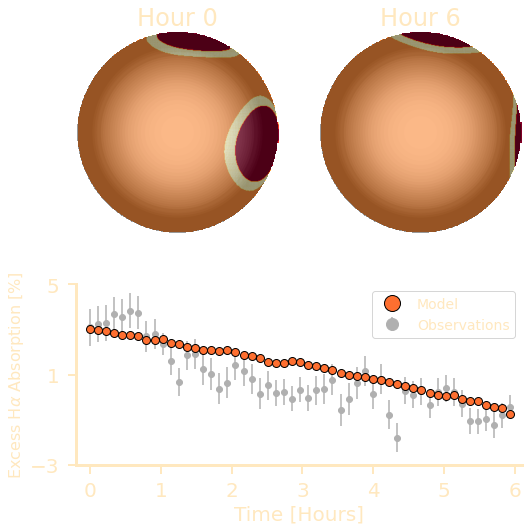

In [95]:
fig2 = plt.figure(constrained_layout=True, figsize=(8,8))
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig2,
                          height_ratios=[2,1.75])
ax1 = fig2.add_subplot(spec2[0, 0])
ax3 = fig2.add_subplot(spec2[0, 1])
ax2 = fig2.add_subplot(spec2[1, :])

norm_widths = equiv_widths/np.nanmedian(equiv_widths)
start=75

hl = np.where((lc[0]>=lc[2][0]) & (lc[0]<=lc[2][-1]))[0]
tlc_tot = (Time(lc[0], format='jd').mjd - Time(lc[0], format='jd').mjd[0]) * units.day
tlc_tot = tlc_tot.to(units.hour) - tlc_tot[hl][0]

plotting = np.linspace(tlc_tot[hl][0].value, tlc_tot[hl][-1].value, 53)

ax2.errorbar(plotting, halpha[0], yerr=halpha[1], marker='o', 
             ms=6, color='#b0b0b0', linestyle='', zorder=1,
             label='Observations')
ax2.plot(plotting, equiv_widths[start:start+53], 'o', color='#FE6F30',
         markeredgecolor='k', ms=8, label='Model')
ax2.legend(fontsize=14)

ax2.set_ylim(-3.0,5.0)
ax2.set_yticks(np.round(np.linspace(-3,5.0,3),1))
ax2.set_xlim(-0.2,6.1)
ax2.set_ylabel(r'Excess H$\alpha$ Absorption [%]', fontsize=16)
ax2.set_xlabel('Time [Hours]')


###########################
##### DRAWS THE MAPS #####
###########################

# LIMB DARKENING MAP #
mask = np.full(ld_star.shape, np.nan)
x,y = np.where(ld_star<0.5)
mask[x,y] = ld_star[x,y]

dat = np.load(surface_fns[start])
ax1.imshow(dat, origin='lower', cmap='YlOrRd_r')
ax1.imshow(ld_star, vmin=0.5, vmax=1., cmap='Greys_r', alpha=0.4,
           origin='lower')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_title('Hour {}'.format(int(np.round(tlc_tot[hl][0].value,0))))

dat = np.load(surface_fns[start+53])
ax3.imshow(dat, origin='lower', cmap='YlOrRd_r')
ax3.imshow(ld_star, vmin=0.5, vmax=1., cmap='Greys_r', alpha=0.4,
           origin='lower')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_title('Hour {}'.format(int(np.round(tlc_tot[hl][-1].value,0))))

ax1.spines.left.set_visible(False)
ax1.spines.bottom.set_visible(False)
ax3.spines.left.set_visible(False)
ax3.spines.bottom.set_visible(False)

ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)

plt.subplots_adjust(wspace=0.2, hspace=0.25)
plt.savefig(os.path.join('/Users/arcticfox/Documents/misc_presentations/','starry_model.png'), 
            rasterize=True, transparent=True,
            bbox_inches='tight', dpi=250)

In [89]:
from matplotlib.colors import LinearSegmentedColormap

def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb

clist = np.array(['#FEB06E', '#FD6B2D', '#FD3517'])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

colormap = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

from pylab import cm

cmap = cm.get_cmap(colormap, 53)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)
colors = colors[np.linspace(0,len(colors)-1,len(halpha[0]),dtype=int)]

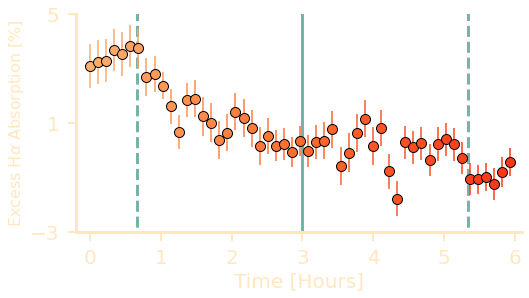

In [94]:
fig, ax2 = plt.subplots(figsize=(8,4))

for i in range(53):
    ax2.errorbar(plotting[i], halpha[0][i], yerr=halpha[1][i], marker='o', 
                 ms=10, c=colors[i], linestyle='', zorder=2,
                 markeredgecolor='k')

ax2.vlines(3,-4,10, lw=3, color='#74B5AA', zorder=1)
ax2.vlines(3-2.33,-4,10, lw=3, color='#74B5AA', zorder=1, linestyle='--')
ax2.vlines(3+2.33,-4,10, lw=3, color='#74B5AA', zorder=1, linestyle='--')

ax2.set_ylim(-3.0,5.0)
ax2.set_yticks(np.round(np.linspace(-3,5.0,3),1))
ax2.set_xlim(-0.2,6.1)
ax2.set_ylabel(r'Excess H$\alpha$ Absorption [%]', fontsize=16)
ax2.set_xlabel('Time [Hours]')
plt.savefig(os.path.join('/Users/arcticfox/Documents/misc_presentations/','halpha.png'), 
            rasterize=True, transparent=True,
            bbox_inches='tight', dpi=250)